# Load packages

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

# Helper functions

In [22]:
pd.set_option( 'display.precision', 2)
def ClassificationReport( Y, y_pred ):
    from sklearn.metrics import classification_report
    from math import sqrt
    temp = classification_report( Y, y_pred )
    temp = temp.splitlines()
    temp.remove("")
    temp.remove("")
    cols = temp[0].split()
    cols.insert(0, "AMD severity")
    temp = [ [ float(inner) for inner in outer.split()] for outer in temp[1:-1] ]
    temp = pd.DataFrame.from_records(temp, columns=cols)
    temp.index = temp['AMD severity'].astype(int)
    temp.drop( 'AMD severity', axis=1, inplace=True)
    results = pd.DataFrame( data={'pred':y_pred, 'act': Y} )
    means = []
    stdevs = []
    mean_abs_error = []
    mean_sq_error = []    
    for act, sub in results.groupby( 'act' ):
        means.append( sub['pred'].mean() )
        stdevs.append( sub['pred'].std() )
        thing = sub['pred'] - sub['act']
        mean_abs_error.append( thing.mean() )
        mean_sq_error.append( sqrt( (thing ** 2).mean() ) )
    temp.insert( len(temp.columns)-1, 'mean', means )
    temp.insert( len(temp.columns)-1, 'mean err', mean_abs_error )
    temp.insert( len(temp.columns)-1, 'std', stdevs )
    temp.insert( len(temp.columns)-1, 'RMSE', mean_sq_error )
    w_prec = ( temp['precision'] * temp['support'] ).sum() / temp['support'].sum()
    w_rec = ( temp['recall'] * temp['support'] ).sum() / temp['support'].sum()
    w_f1 = ( temp['f1-score'] * temp['support'] ).sum() / temp['support'].sum()
    w_mean = ( temp['mean'] * temp['support'] ).sum() / temp['support'].sum()
    w_std = ( temp['std'] * temp['support'] ).sum() / temp['support'].sum()
    w_mae = ( temp['mean err'] * temp['support'] ).sum() / temp['support'].sum()
    w_mse = ( temp['RMSE'] * temp['support'] ).sum() / temp['support'].sum()
    
    temp.loc[ 'w_avg/tot'] = [ w_prec, w_rec, w_f1, w_mean, w_mae, w_std, w_mse, int(temp['support'].sum())]
    temp['support']= temp['support'].astype(int)
    return temp

In [3]:
def ordered_uniq( labels ):
    seen = set()
    seen_add = seen.add
    return [ x for x in labels if not (x in seen or seen_add(x) ) ]

def KernelSmoothedDensityGraph( labels, predicted_values, bw_method=None, figsize=(7, 4),
        chart_title=None, fontsize=12, titlefontsize=14, linewidth=2, fig=None, ax=None ):
    """This graph visualizes the distribution of predicted values generated by classification.
    A kernel-smoothed probability density function is plotted for each image class on
    the same chart allowing comparison of distribution of predicted values amoung image class.

    Requires the packages matplotlib and scipy. Uses scipy.stats.gaussian_kde to
    generate kernel-smoothed probability density functions.

    labels - iterable
        Ground truth numeric labels for the sample set.
    predicted_values - iterable
        Predicted values (numbers) for a given set of samples.
    bw_method -
        Arg passed directly to bw_method arg in scipy.stats.gaussian_kde
    fig - matplotlib.figure.Figure, or None (default):
        If provided, generate axes on the passed-in figure obj, otherwise
        instantiate a new one.
    ax - matplotlib.axes._subplots.AxesSubplot or None (default):
        Plot data on these axes, if provided, otherwise create new axes on figure."""

    import matplotlib.pyplot as plt

    if fig is None and ax is None:
        fig = plt.figure( figsize=figsize )
        ax = fig.add_subplot(111)
    elif fig is None:
        fig = ax.get_figure()
    elif ax is None:
        ax = fig.gca()

    ax.set_title( chart_title, size=titlefontsize )
    ax.set_xlabel( 'Predicted Value', size=fontsize )
    ax.set_ylabel( 'Probability density', size=fontsize )

    predicted_values = np.array( predicted_values )
    labels = np.array( labels )
    class_values = ordered_uniq( labels )
    n_classes = len( class_values )

    _min = min( class_values )
    ampl = max( class_values ) - _min
    class_colors = plt.cm.jet( [ float(val -_min)/ampl for val in class_values ] )

    from scipy.stats import gaussian_kde

    # For now, ignore "FloatingPointError: underflow encountered in exp'"
    np.seterr( under='ignore' )

    for class_value, class_color in zip( class_values, class_colors ):
        # convert list of bools to the indices that eval to True:
        # why does numpy where return a 1-tuple??
        indices = np.where( [ l == class_value for l in labels ] )[0]
        class_pred_vals = predicted_values[ indices ]
        ground_truth_vals = labels[ indices ]

        lobound = class_pred_vals.min()
        hibound = class_pred_vals.max()
        kernel_smoother = gaussian_kde( class_pred_vals, bw_method=bw_method )
        intervals = np.mgrid[ lobound:hibound:100j ]
        density_estimates = kernel_smoother.evaluate( intervals )
        ax.plot( intervals, density_estimates, c=class_color,
            linewidth=linewidth, label=class_value )

    np.seterr( all='raise' )

    ax.legend( fontsize=fontsize, bbox_to_anchor=(1.05, 1) )
    return fig


# Load raw data

In [4]:
feature_names = [ line.rstrip('\n') for line in open( 'left_new_severity_with_11_12_feature_names.txt' )]

In [5]:
raw = pd.DataFrame( columns=feature_names, data=np.load( 'left_new_severity_with_11_12_data.npy' ) )
raw['side'] = [1]* len(raw)
n_samples, n_features = raw.shape
raw['group'] = [ int(i) for i in range( int(n_samples/8) ) for j in range( 8 ) ]
raw['actual'] = [ int(line.rstrip('\n')) for line in open( 'left_new_severity_with_11_12_values.txt' )]
averaged = pd.concat( [ g.mean(axis=0) for n, g in raw.groupby( 'group' ) ], 
                     axis=1, ignore_index=True).T
averaged.drop('group', axis=1, inplace=True)

In [6]:
import time

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

# Support Vector Classifier

In [8]:
steps = []
steps.append( ('standardize', StandardScaler() ) )
steps.append( ('svc', SVC(probability=True, class_weight='balanced') ) )
svc_model = Pipeline( steps )

In [9]:
cv_strategy = KFold( n_splits=8, shuffle=True, random_state=42)

In [10]:
X = averaged.iloc[:,:-2]
Y = np.array(list(averaged.actual)) 

In [11]:
t1 = time.time()
y_pred_svc = cross_val_predict( svc_model, X, Y, cv=cv_strategy, 
                              method='predict', n_jobs=8 )
t2 = time.time()
print( "took {:0.1f}min".format( (t2-t1)/60 ) )

took 7.1min


In [13]:
y_pred_svc = [ int(_) for _ in y_pred_svc ]

### Save SVC output

In [15]:
with open( 'left_new_severity_12_class_svc_y_pred.txt', 'w' ) as f:
    for a, b in zip( Y, y_pred_svc ):
        f.write( '{}\t{}\n'.format( a, b ) )

## SVC Model Evaluation

### Report

* precision = TP / (TP + FP) How many selected items are relevant?
* recall = TP/P = TP / (TP+TN) = true positives ("sensitivity")
* f1-score = mean of precision and recall
* support = n instances in class

In [23]:
ClassificationReport( Y, y_pred_svc)

,precision,recall,f1-score,mean,mean err,std,RMSE,support
AMD severity,,,,,,,,
1,0.30,0.60,0.40,2.34,1.34,2.22,2.59,325
2,0.19,0.08,0.12,3.05,1.05,2.26,2.49,323
3,0.21,0.27,0.24,3.68,0.68,2.57,2.66,325
4,0.15,0.14,0.14,3.80,-0.20,2.81,2.81,296
5,0.17,0.15,0.16,4.53,-0.47,2.83,2.86,325
6,0.18,0.15,0.16,5.17,-0.83,2.82,2.93,324
7,0.31,0.21,0.25,6.28,-0.72,2.63,2.72,325
8,0.26,0.26,0.26,6.84,-1.16,2.48,2.74,325
9,0.30,0.30,0.30,8.23,-0.77,2.31,2.44,271


### Confusion Matrix

In [17]:
cm = confusion_matrix( Y, y_pred_svc )

In [18]:
cm_normal = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

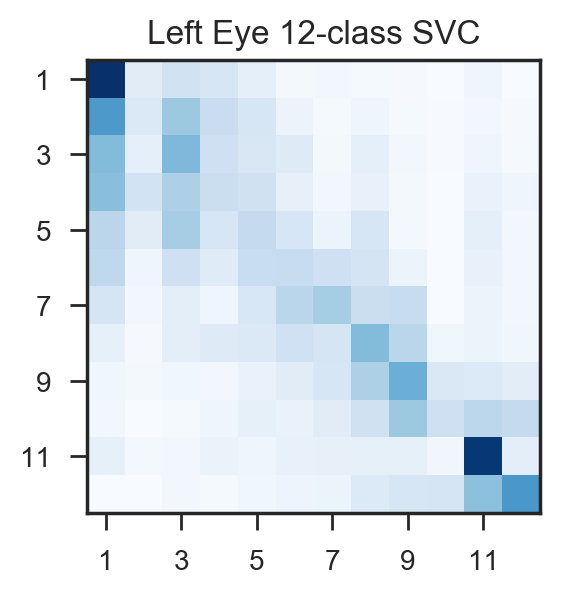

In [73]:
sns.set_style(style='ticks')
fig = plt.figure( figsize=(3,3), dpi=200 )
ax = fig.gca()
ax.imshow( cm_normal, interpolation='nearest', cmap=plt.cm.Blues)
ax.set_title( "Left Eye 12-class SVC" )
ax.set_yticks( list( range(0,12,2) ) )
ax.set_xticks( list( range(0,12,2) ) )
ax.set_xticklabels( [str(_) for _ in range(1,12,2)] )
ax.set_yticklabels( [str(_) for _ in range(1,12,2)] )
fig.savefig( 'paper/images/left_new_severity_12_class_svc_y.pdf' )

## Residuals versus actual

In [69]:
results = pd.DataFrame( data={'pred':y_pred_svc, 'act': Y} )
results[ 'residual' ] = results['pred'] - results['act']

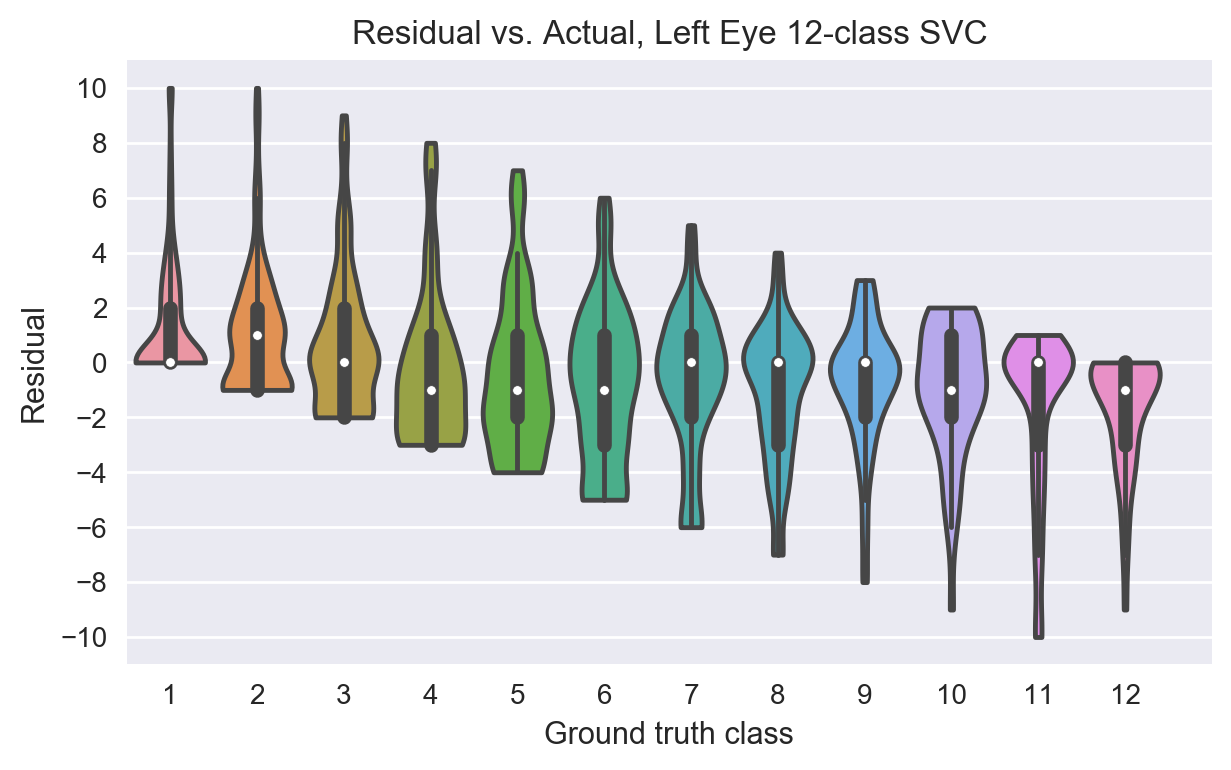

In [70]:
sns.set_style(style='darkgrid')
fig = plt.figure( figsize=(7,4), dpi=200 )
ax = fig.gca()
ax.set_yticks( list( range( -10, 12, 2) ) )
sns.violinplot( x='act', y='residual', data=results, ax=ax, cut=0, scale='width')
ax.set_xticks( list( range(0,13) ) )
ax.set_xticklabels( [str(_) for _ in range(1,13)] )
ax.set_title( "Residual vs. Actual, Left Eye 12-class SVC" )
ax.set_xlabel( "Ground truth class")
ax.set_ylabel( "Residual")
fig.savefig( 'paper/images/left_new_severity_12_class_svc_resid_vs_act.pdf' )

## Residuals versus predicted

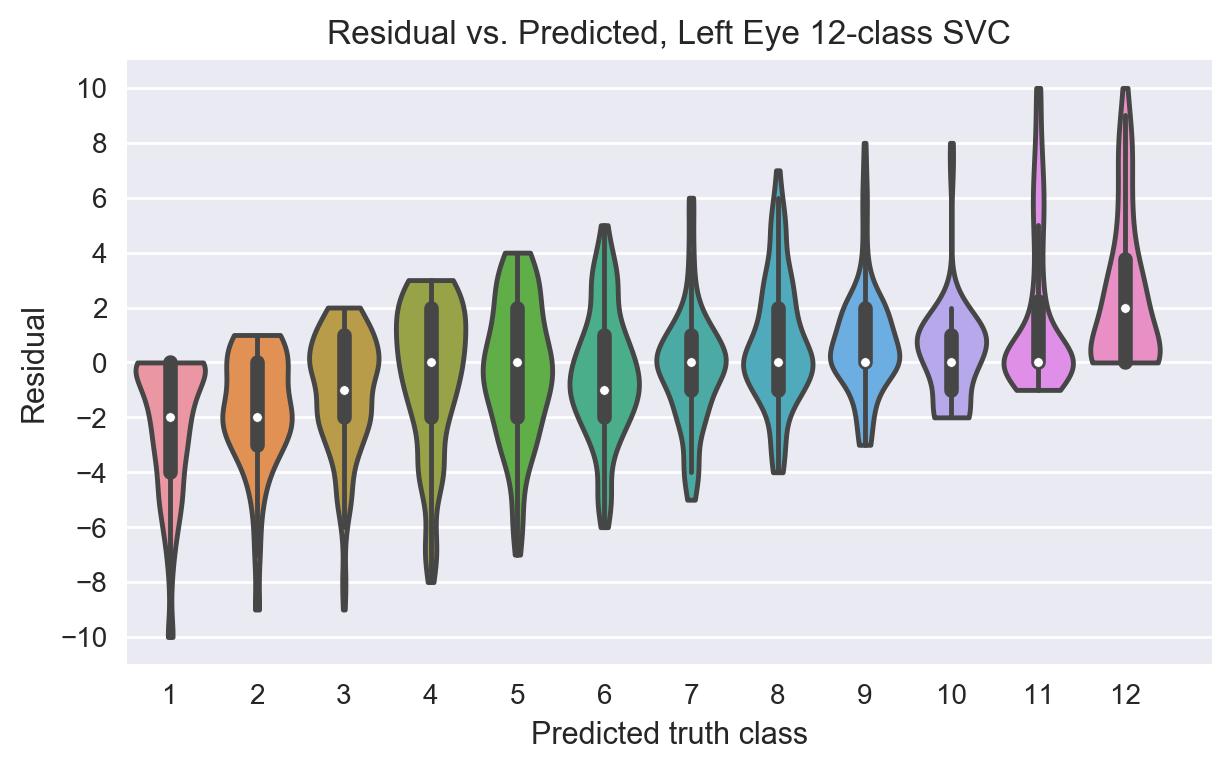

In [71]:
sns.set_style(style='darkgrid')
fig = plt.figure( figsize=(7,4), dpi=200 )
ax = fig.gca()
ax.set_yticks( list( range( -10, 12, 2) ) )
sns.violinplot( x='pred', y='residual', data=results, ax=ax, cut=0, scale='width')
ax.set_xticks( list( range(0,13) ) )
ax.set_xticklabels( [str(_) for _ in range(1,13)] )
ax.set_title( "Residual vs. Predicted, Left Eye 12-class SVC" )
ax.set_xlabel( "Predicted truth class")
ax.set_ylabel( "Residual")
fig.savefig( 'paper/images/left_new_severity_12_class_svc_resid_vs_pred.pdf' )

# Support Vector Regressor

In [54]:
from sklearn.svm import SVR

In [55]:
steps = []
steps.append( ('standardize', StandardScaler() ) )
steps.append( ('svc', SVR( cache_size=5000) ) )
svr_model = Pipeline( steps )

In [56]:
t1 = time.time()
y_pred_svr = cross_val_predict( svr_model, X, Y, cv=cv_strategy, 
                              method='predict', n_jobs=8 )
t2 = time.time()
print( "took {:0.1f}min".format( (t2-t1)/60 ) )

took 2.1min


### Save SVR output

In [57]:
with open( 'left_new_severity_12_class_svr_y_pred.txt', 'w' ) as f:
    for a, b in zip( Y, y_pred_svr ):
        f.write( '{}\t{}\n'.format( a, b ) )

## SVR Model Evaluation

### R^2

In [58]:
from sklearn.metrics import r2_score

In [59]:
r2_score(Y, y_pred_svr)

0.54120257887894629

In [60]:
results = pd.DataFrame( data={'pred':y_pred_svr, 'act': Y} )
results[ 'residual' ] = results['pred'] - results['act']

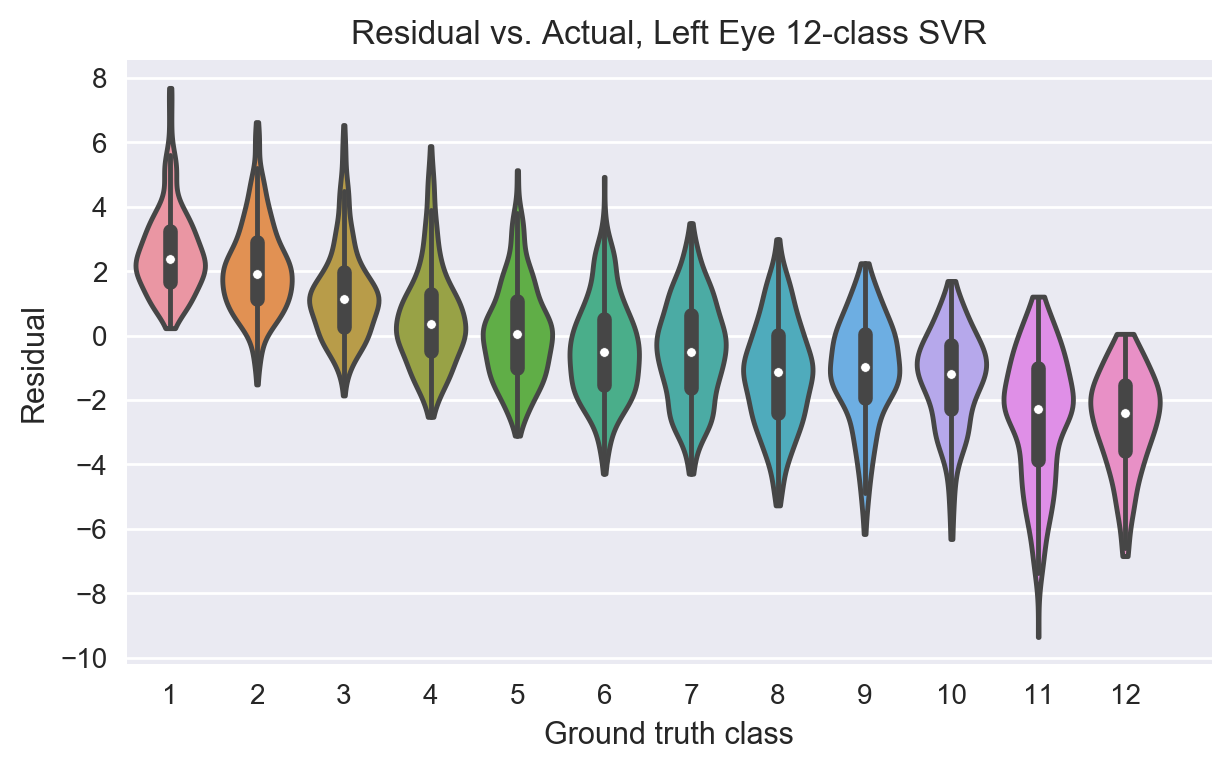

In [68]:
sns.set_style(style='darkgrid')
fig = plt.figure( figsize=(7,4), dpi=200 )
ax = fig.gca()
ax.set_yticks( list( range( -10, 12, 2) ) )
sns.violinplot( x='act', y='residual', data=results, ax=ax, cut=0, scale='width')
ax.set_xticks( list( range(0,13) ) )
ax.set_xticklabels( [str(_) for _ in range(1,13)] )
ax.set_title( "Residual vs. Actual, Left Eye 12-class SVR" )
ax.set_xlabel( "Ground truth class")
ax.set_ylabel( "Residual")
fig.savefig( 'paper/images/left_new_severity_12_class_svr_resid_vs_act.pdf' )

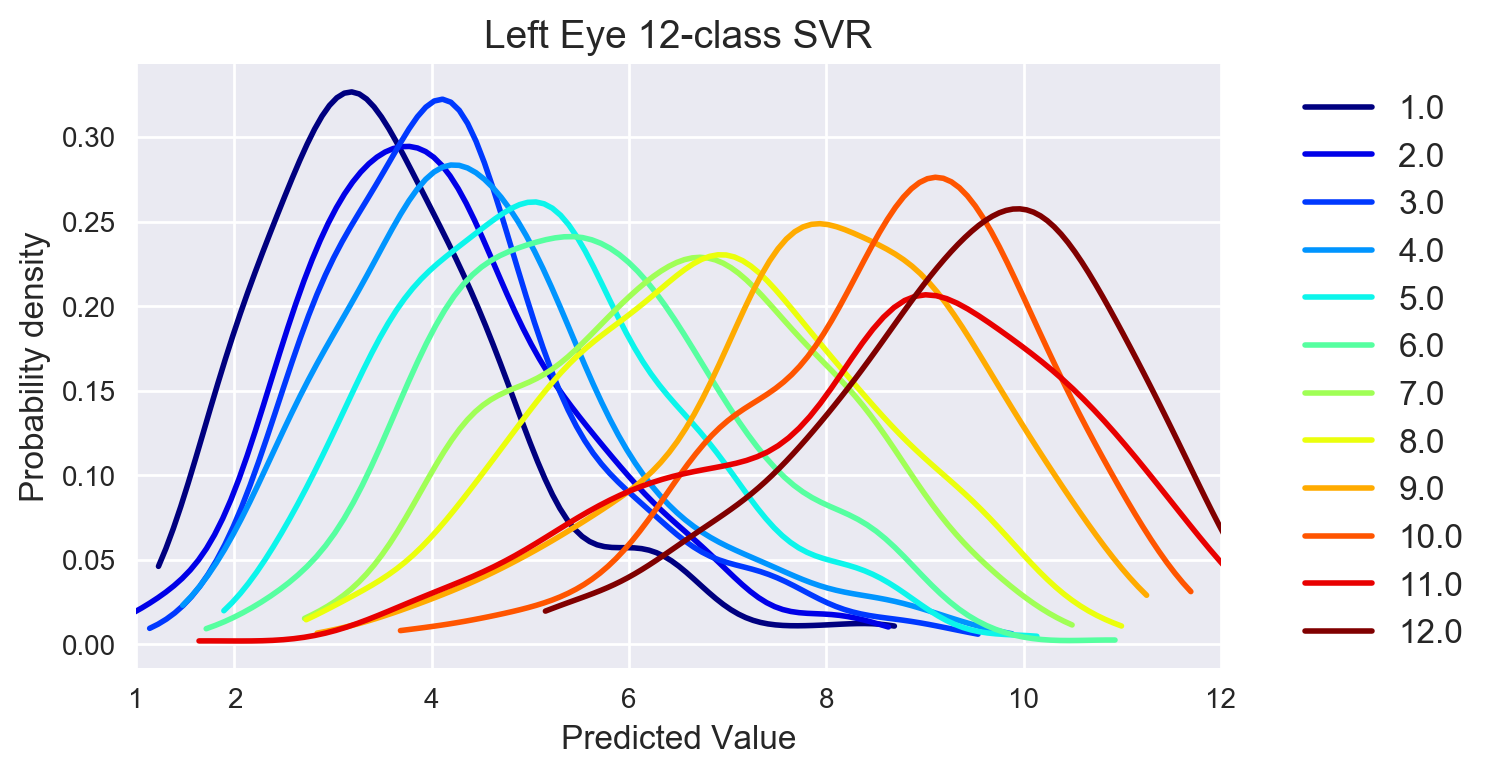

In [72]:
fig = plt.figure( figsize=(7,4), dpi=200 )
ax = fig.gca()
ks_dens = KernelSmoothedDensityGraph( Y, y_pred_svr, fig=fig, ax=ax, chart_title='Left Eye 12-class SVR', )
ax.set_xticks( [1,2,4,6,8,10,12] )
ax.set_xlim( (1,12))
ks_dens.savefig( 'paper/images/left_new_severity_12_class_svr_ksd.pdf')

In [65]:
import statsmodels.formula.api as smf

In [66]:
ols_results = smf.ols('pred ~ act', data=results).fit()

In [67]:
print(ols_results.summary())

                            OLS Regression Results                            
Dep. Variable:                   pred   R-squared:                       0.542
Model:                            OLS   Adj. R-squared:                  0.541
Method:                 Least Squares   F-statistic:                     4020.
Date:                Tue, 15 Aug 2017   Prob (F-statistic):               0.00
Time:                        10:20:37   Log-Likelihood:                -6423.2
No. Observations:                3406   AIC:                         1.285e+04
Df Residuals:                    3404   BIC:                         1.286e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.7654      0.057     48.697      0.0

# LDA classification and feature space transform

In [45]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

In [53]:
steps = []
steps.append( ('standardize', StandardScaler() ) )
steps.append( ('svc', LDA() ) )
lda_model = Pipeline( steps )

In [54]:
cv_strategy = KFold( n_splits=8, shuffle=True, random_state=42 )

In [ ]:
t1 = time.time()
y_pred_lda = cross_val_predict( lda_model, X, Y, cv=cv_strategy, 
                              method='predict', n_jobs=8 )
t2 = time.time()
print( "took {:0.1f}min".format( (t2-t1)/60 ) )

/usr/local/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:455: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/usr/local/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:455: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


# Marginal Probabilities

In [27]:
t1 = time.time()
marg_probs = cross_val_predict( model, X, Y, cv=cv_strategy, 
                              method='predict_proba', n_jobs=8 )
t2 = time.time()
print( "took {:0.1f}s".format( t2-t1 ) )

took 402.6s


In [28]:
y_pred_marg = np.argmax( marg_probs, axis=1 ) + 1

# Purify datasets

In [32]:
severity = pd.DataFrame( data={'true': Y, 'pred': y_pred })

In [33]:
pure = severity[ severity.pred == severity.true]
pure.true.value_counts()

1.0     196
9.0     102
8.0      88
3.0      86
7.0      69
6.0      49
5.0      47
4.0      38
10.0     30
2.0      24
Name: true, dtype: int64

In [34]:
len(severity)

2958

In [43]:
min_samp_per_class = 50
desired_indices = []
for i in range(1,11):
    sub = pure[ pure.true == i]
    n_samps = min( min_samp_per_class, len( sub ) )
    subsub = sub.sample( n_samps )
    desired_indices.extend( list( subsub.index ) )

In [44]:
desired_indices.sort()

(array([ 49.,  23.,  46.,  32.,  41.,  56.,  35.,  44.,  47.,  65.]),
 array([    8. ,   302.9,   597.8,   892.7,  1187.6,  1482.5,  1777.4,
         2072.3,  2367.2,  2662.1,  2957. ]),
 <a list of 10 Patch objects>)

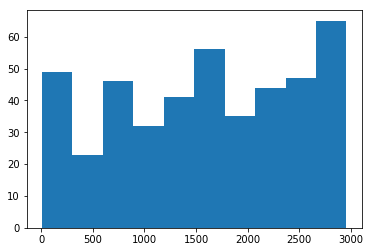

In [45]:
plt.hist(desired_indices)

In [46]:
len(desired_indices)

438

In [47]:
averaged.shape

(2958, 4061)

In [48]:
purified = averaged.loc[ desired_indices ]

In [49]:
purified.shape

(438, 4061)

In [50]:
purified.to_csv('purified_left_eye.pandas.csv', index=False)